In [1]:
import fastai
from fastai.vision.all import *
from tqdm import tqdm
from glob import glob

/userHome/userhome4/seungyeon/miniconda3/envs/nih_syn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 85
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(SEED)

In [3]:
labels_train_val = pd.read_csv('../../../../..//data/train_val_list.txt')
labels_train_val.columns = ['Image_Index']
labels_test = pd.read_csv('../../../../..//data/test_list.txt')
labels_test.columns = ['Image_Index']
disease_labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'No Finding']
# NIH Dataset Labels CSV File 
labels_df = pd.read_csv('../../../../..//data/Data_Entry_2017.csv')
labels_df.columns = ['Image_Index', 'Finding_Labels', 'Follow_Up_#', 'Patient_ID',
                  'Patient_Age', 'Patient_Gender', 'View_Position',
                  'Original_Image_Width', 'Original_Image_Height',
                  'Original_Image_Pixel_Spacing_X',
                  'Original_Image_Pixel_Spacing_Y', 'dfd']
# One hot encoding
for diseases in tqdm(disease_labels): 
    labels_df[diseases] = labels_df['Finding_Labels'].map(lambda result: 1 if diseases in result else 0)

# labels_df.to_csv('/kaggle/working/newData.csv')
# labels_df=labels_df[labels_df.Finding_Labels != 'No Finding']
# #labels_df.head(3)

100%|██████████| 14/14 [00:00<00:00, 39.45it/s]


In [4]:
labels_df['Finding_Labels'] = labels_df['Finding_Labels'].apply(lambda s: [l for l in str(s).split('|')])

num_glob = glob('../../../../../data/images_all/*.png')
img_path = {os.path.basename(x): x for x in num_glob}

labels_df['Paths'] = labels_df['Image_Index'].map(img_path.get)
labels_df.head()

,Image_Index,Finding_Labels,Follow_Up_#,Patient_ID,Patient_Age,Patient_Gender,View_Position,Original_Image_Width,Original_Image_Height,Original_Image_Pixel_Spacing_X,...,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia,Paths
0,00000001_000.png,[Cardiomegaly],0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,1,0,0,0,../../../../../data/images_all/00000001_000.png
1,00000001_001.png,"[Cardiomegaly, Emphysema]",1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,1,0,0,0,../../../../../data/images_all/00000001_001.png
2,00000001_002.png,"[Cardiomegaly, Effusion]",2,1,58,M,PA,2500,2048,0.168,...,0,0,1,0,0,1,0,0,0,../../../../../data/images_all/00000001_002.png
3,00000002_000.png,[No Finding],0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,0,0,0,0,../../../../../data/images_all/00000002_000.png
4,00000003_000.png,[Hernia],0,3,81,F,PA,2582,2991,0.143,...,0,0,0,0,0,0,0,0,1,../../../../../data/images_all/00000003_000.png


In [5]:
unique_patients = np.unique(labels_df['Patient_ID'])
len(unique_patients)

30805

In [6]:
from sklearn.model_selection import train_test_split

# train-70
# val-10
# test-20
train_val_df_patients, test_df_patients = train_test_split(unique_patients, 
                                   test_size = 0.2,
                                   random_state = SEED,
                                    shuffle= True
                                   )
len(train_val_df_patients)

24644

In [7]:
len(labels_df)

112120

In [8]:
train_val_df = labels_df[labels_df['Patient_ID'].isin(train_val_df_patients)]

In [9]:
train_val_df.head()

,Image_Index,Finding_Labels,Follow_Up_#,Patient_ID,Patient_Age,Patient_Gender,View_Position,Original_Image_Width,Original_Image_Height,Original_Image_Pixel_Spacing_X,...,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia,Paths
0,00000001_000.png,[Cardiomegaly],0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,1,0,0,0,../../../../../data/images_all/00000001_000.png
1,00000001_001.png,"[Cardiomegaly, Emphysema]",1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,1,0,0,0,../../../../../data/images_all/00000001_001.png
2,00000001_002.png,"[Cardiomegaly, Effusion]",2,1,58,M,PA,2500,2048,0.168,...,0,0,1,0,0,1,0,0,0,../../../../../data/images_all/00000001_002.png
4,00000003_000.png,[Hernia],0,3,81,F,PA,2582,2991,0.143,...,0,0,0,0,0,0,0,0,1,../../../../../data/images_all/00000003_000.png
5,00000003_001.png,[Hernia],1,3,74,F,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,1,../../../../../data/images_all/00000003_001.png


In [10]:
labels_df.shape
print('train_val size', train_val_df.shape[0])
print('test size', labels_df.shape[0] - train_val_df.shape[0])

train_val size 89764
test size 22356


In [11]:
item_transforms = [
    Resize((224, 224)),
]

batch_transforms = [
    Flip(),
    Rotate(),
    Normalize.from_stats(*imagenet_stats),
]


def get_x(row):
    return row['Paths']

def get_y(row):
    labels = row[disease_labels].tolist()
    return labels

dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock(encoded=True,vocab=disease_labels)),
                   splitter=RandomSplitter(valid_pct=0.125, seed=SEED),
                   get_x=get_x,
                   get_y=get_y,
                   item_tfms=item_transforms,
                   batch_tfms=batch_transforms
                  )
dls = dblock.dataloaders(train_val_df, bs=32)
# print(dblock.datasets(train_val_merge).train)

In [12]:
from fastai.vision.all import *

arch = 'coatnet_2_rw_224.sw_in12k_ft_in1k'

cbs=[
    SaveModelCallback(monitor='valid_loss', min_delta=0.001, with_opt=True),
    EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=5),
    ShowGraphCallback()
    ]

learn = vision_learner(dls, arch, metrics=[accuracy_multi, F1ScoreMulti(), RocAucMulti()],cbs=cbs, wd=0.001)

learn.model = torch.nn.DataParallel(learn.model)

intial learning rate= 0.00363078061491251


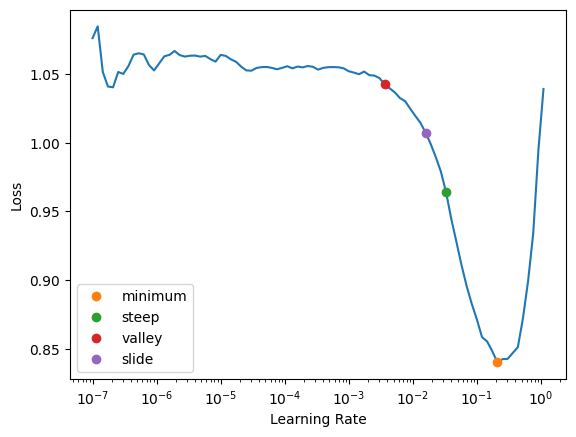

In [13]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
print('intial learning rate=', lrs.valley)

In [14]:
learn.fine_tune(freeze_epochs=3,epochs=20, base_lr=lrs.valley)

epoch,train_loss,valid_loss,accuracy_multi,f1_score,roc_auc_score,time


KeyboardInterrupt: 

In [ ]:
learn.save('coatnet-70-10-20-split')

Path('models/coatnet-70-10-20-split.pth')